# Data mining \& clustering

The goal if this practical is to adress the folowing problem: 
<center style="color:red" >  Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</center>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X = 
	\begin{matrix} 
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix} 
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import sklearn

## Data loading



In [3]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [4]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer() 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
44.164928407283014


In [5]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(199, 'cases'), (614, 'moral'), (391, 'finally'), (758, 'religious'), (200, 'cause'), (821, 'shall'), (986, 'works'), (498, 'interesting'), (552, 'limited'), (759, 'remember')]


In [11]:
# labels (only for evaluation)
# We have 20 different classes into which we want to classify our documents
Y = newsgroups_train.target
print(Y[:10]) 
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds 
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

### Let's look at the most frequent words in this dataset

In [25]:
from collections import Counter
data = np.array(newsgroups_train.data)
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nb mots=",len(words))
# Lets find the most frequent words Your code here
count = Counter(words)
most_frequent = count.most_common(100)

Nb mots= 3252437


### Plot the N frequent words and verify that its follows a Zipf law

Text(0.5, 0, 'word')

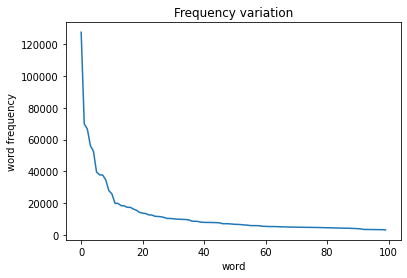

In [26]:
# Your code here
import matplotlib.pyplot as plt

w, freq = [], []
for i,v in enumerate(most_frequent):
    w.append(i)
    freq.append(v[1])

plt.plot(w, freq)
plt.title('Frequency variation')
plt.ylabel('word frequency')
plt.xlabel('word')

### Experiment word clouds

(-0.5, 399.5, 199.5, -0.5)

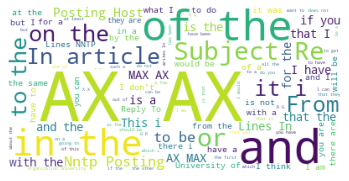

In [12]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus)            

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')

**Review :**

We clearly observe that the words that occurs the most are stop words (connectors etc), it might be interesting to remove this words and analyse the results of the visualisation.

(-0.5, 399.5, 199.5, -0.5)

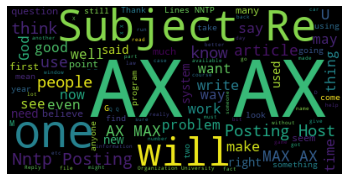

In [15]:
from wordcloud import STOPWORDS # Note: this is the default option           
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies. 
N.B.: retrieve the most words frequencies using a CountVectorizer

In [40]:
# Use of CountVectorizer from sklearn to calculate word frequencies
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words=STOPWORDS)
cv_fit = cv.fit_transform(newsgroups_train.data)
word_frequencies = cv_fit.toarray().sum(axis=0)
sum_words = cv_fit.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

words_freq

[('ax', 62406),
 ('edu', 21321),
 ('subject', 12264),
 ('lines', 11835),
 ('organization', 11233),
 ('re', 10531),
 ('will', 9279),
 ('one', 9008),
 ('writes', 7844),
 ('article', 7438),
 ('people', 5975),
 ('don', 5953),
 ('university', 5586),
 ('posting', 5507),
 ('know', 5128),
 ('host', 4996),
 ('nntp', 4814),
 ('max', 4690),
 ('think', 4578),
 ('use', 4183),
 ('time', 4093),
 ('new', 3971),
 ('good', 3758),
 ('ca', 3544),
 ('well', 3478),
 ('us', 3360),
 ('may', 3310),
 ('even', 3279),
 ('now', 3210),
 ('see', 3064),
 ('cs', 3036),
 ('two', 3015),
 ('way', 3002),
 ('god', 2994),
 ('first', 2974),
 ('many', 2943),
 ('make', 2894),
 ('much', 2876),
 ('system', 2817),
 ('distribution', 2766),
 ('right', 2739),
 ('world', 2721),
 ('say', 2704),
 ('ve', 2568),
 ('want', 2515),
 ('go', 2474),
 ('anyone', 2467),
 ('reply', 2463),
 ('10', 2462),
 ('used', 2456),
 ('said', 2453),
 ('need', 2413),
 ('work', 2366),
 ('state', 2268),
 ('something', 2248),
 ('problem', 2224),
 ('please', 2202)

(-0.5, 399.5, 199.5, -0.5)

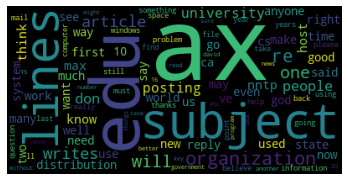

In [46]:
# Your code here
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS, max_words=100)
wordcloud.generate_from_frequencies(frequencies=dict(words_freq))

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Drawing word clouds from classes


In [17]:
punctuation = r"[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~\n\t]"
corpus_punc = re.sub(punctuation, " ", corpus)
corpus_punc = re.sub('( )+', ' ', corpus_punc).lower()

In [18]:
def word_cloud_from_classes(Y):
    """
    Plots a wordcloud for each class in our dataset with the most frequent words it contains
    """
    for y in np.unique(Y):
        # Index of documents belonging to y class
        idx = np.where(Y==y)[0]
        corpus_y = ' '.join(data[idx])
        corpus_y = re.sub('( )+', ' ', re.sub(punctuation, " ", corpus_y))
        wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS, max_words=100).generate(corpus_y) 
        plt.figure()
        plt.title(y)
        plt.imshow(wordcloud)
        plt.axis("off")

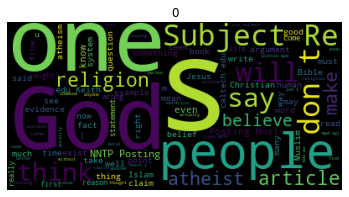

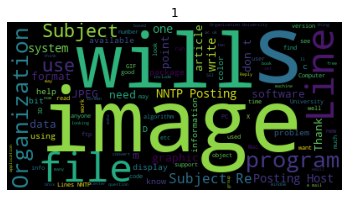

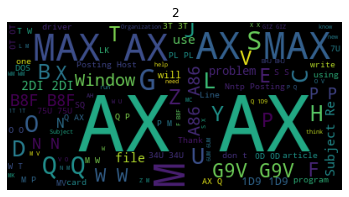

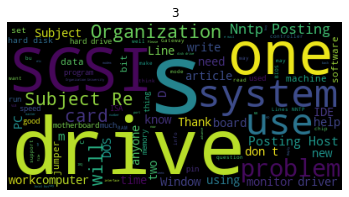

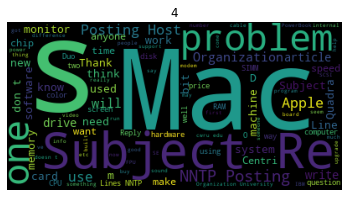

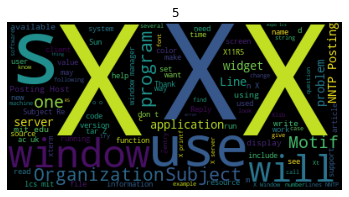

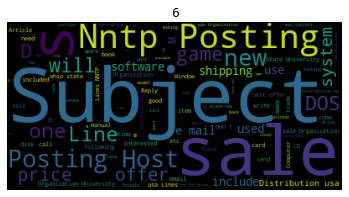

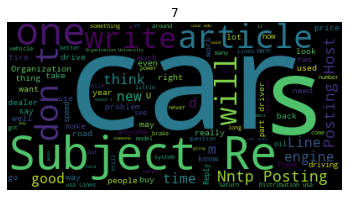

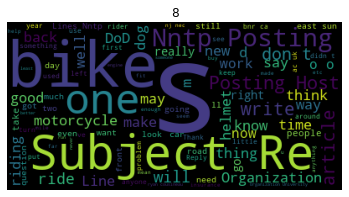

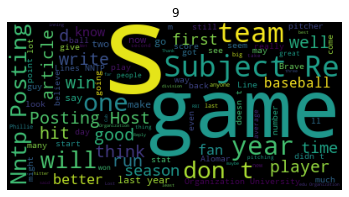

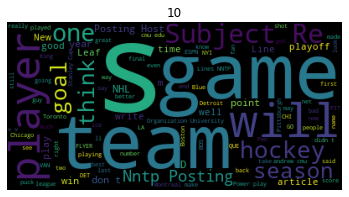

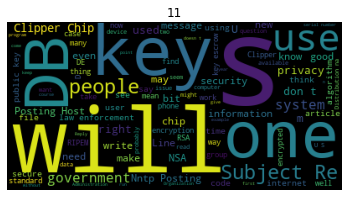

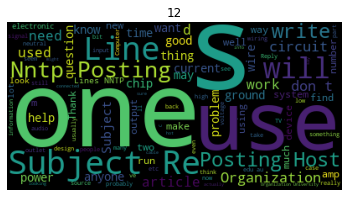

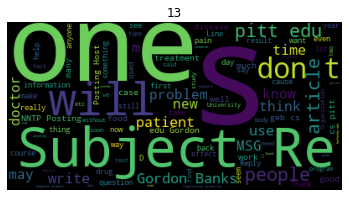

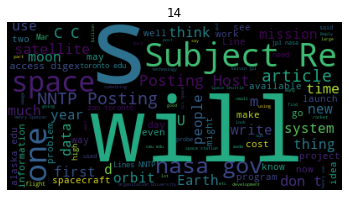

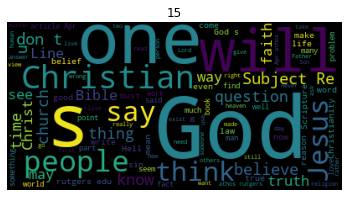

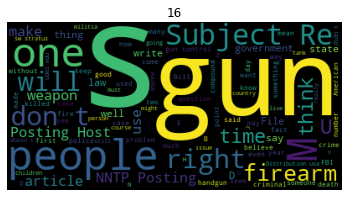

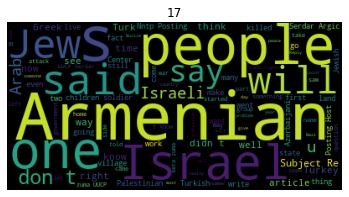

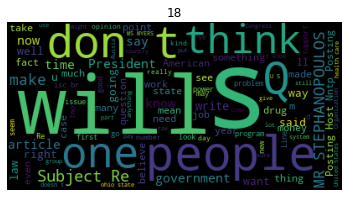

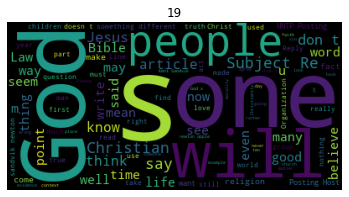

In [19]:
word_cloud_from_classes(Y)

# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


### Clustering Analysis: 
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)

In [121]:
from sklearn.cluster import KMeans
# K-means algorithm requires the number of clusters as a parameter
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
kmeans.cluster_centers_

array([[2.38315266e-01, 1.14181624e-01, 8.19264262e-02, ...,
        4.73609383e-02, 4.46063622e-02, 2.61240448e-02],
       [1.59000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.80000000e+01],
       [7.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.50000000e+01],
       ...,
       [9.00000000e+01, 1.00000000e+01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.94000000e+02, 4.50000000e+01, 0.00000000e+00, ...,
        0.00000000e+00, 3.00000000e+00, 0.00000000e+00],
       [6.05000000e+02, 0.00000000e+00, 5.00000000e+00, ...,
        0.00000000e+00, 5.00000000e-01, 0.00000000e+00]])

## Qualitative clustering analysis

First thing first, we show the most frequent word for each cluster that the k-means algorithm returns.

In [122]:
cluster_mfw = [np.argmax(kmeans.cluster_centers_[i]) for i in range(len(kmeans.cluster_centers_))]
for i,e in enumerate(cluster_mfw):
    print(f'The most frequent word in cluster {i+1} : ',words[e])

The most frequent word in cluster 1 :  to
The most frequent word in cluster 2 :  University
The most frequent word in cluster 3 :  University
The most frequent word in cluster 4 :  University
The most frequent word in cluster 5 :  Engineering
The most frequent word in cluster 6 :  University
The most frequent word in cluster 7 :  University
The most frequent word in cluster 8 :  >>
The most frequent word in cluster 9 :  this!?
The most frequent word in cluster 10 :  University
The most frequent word in cluster 11 :  University
The most frequent word in cluster 12 :  University
The most frequent word in cluster 13 :  be
The most frequent word in cluster 14 :  memory.
The most frequent word in cluster 15 :  University
The most frequent word in cluster 16 :  Engineering
The most frequent word in cluster 17 :  be
The most frequent word in cluster 18 :  >>
The most frequent word in cluster 19 :  From:
The most frequent word in cluster 20 :  From:


In [127]:
# Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
# Predict the cluster assignement to each document of the corpus
ypred_km = kmeans.predict(vectors)
# Is it word cloud to each document, or to each cluster => let's do both
# word_cloud_from_classes(y_hat)

2. **Quantitative:**
    - Compute cluster "purity": $p_j= |y^*_j|$, where $y^*_j$ is the most frequent (GT) label in cluster $C_j$ $\Rightarrow$ $p = \frac{1}{N}\sum\limits_j  p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score) 

Purity: Purity is a measure of the extent to which clusters contain a single class.[36] Its calculation can be thought of as follows: For each cluster, count the number of data points from the most common class in said cluster. Now take the sum over all clusters and divide by the total number of data points.

In [128]:
# Compute cluster purity
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

purity_score(Y, ypred_km)

0.05656708502739968

In [129]:
def purity(y_gt, y_hat):
    """
    Plots a wordcloud for each class in our dataset with the most frequent words it contains
    """
    pj = []
    for y in np.unique(y_hat):
        # Index of documents belonging to y class
        idx = np.where(y_hat==y)[0]
        gt = y_gt[idx]
        count = Counter(gt)
        pj.append(count.most_common(1))
    return np.sum(pj)/len(y_gt)

purity(Y, ypred_km)

0.06381474279653526

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. (sickit doc)

The Rand index has a value between 0 and 1, with 0 indicating that the two data clusterings do not agree on any pair of points and 1 indicating that the data clusterings are exactly the same. (wiki)

In [130]:
# Compute rand score
print(sklearn.metrics.rand_score(Y, ypred_km))
# Computer ajusted rand score
print(sklearn.metrics.cluster.adjusted_rand_score(Y, ypred_km))

0.060052901012398255
-3.0650519729433616e-05


In [132]:
# KMeans
evaluate(Y, ypred_km)

Homogeneity: 0.004
Completeness: 0.245
V-measure: 0.007
Adjusted Rand-Index: -0.000


In [131]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []

def fit_and_evaluate(km, X,labels, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time.time()
        km.fit(X)
        train_times.append(time.time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


def evaluate(y_true, y_hat):
    scores = defaultdict(float)
    scores["Homogeneity"] = metrics.homogeneity_score(y_true, y_hat)
    scores["Completeness"] = metrics.completeness_score(y_true, y_hat)
    scores["V-measure"] = metrics.v_measure_score(y_true, y_hat)
    scores["Adjusted Rand-Index"] = (metrics.adjusted_rand_score(y_true, y_hat))

    for score_name, score_value in scores.items():
        print(f"{score_name}: {score_value:.3f}")

In [65]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import time

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time.time()
X_lsa = lsa.fit_transform(vectors)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time.time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 2.170 s
Explained variance of the SVD step: 33.4%


In [66]:
kmeans = KMeans(
    n_clusters=20,
    max_iter=100,
    n_init=1,
)   

fit_and_evaluate(kmeans, X_lsa, Y, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.26 ± 0.06 s 
Homogeneity: 0.292 ± 0.017
Completeness: 0.320 ± 0.018
V-measure: 0.305 ± 0.017
Adjusted Rand-Index: 0.131 ± 0.011
Silhouette Coefficient: 0.070 ± 0.005


In [70]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(20):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: mit window edu motif com server application use internet problem 
Cluster 1: nasa gov space center edu research article writes com laboratory 
Cluster 2: ohio state acs edu university article writes com don nntp 
Cluster 3: gun keith caltech edu guns don com people institute firearms 
Cluster 4: uk ac university writes article edu host posting nntp ed 
Cluster 5: car edu com just like good don time bike know 
Cluster 6: card video drivers monitor edu cards driver windows bus color 
Cluster 7: drive scsi ide drives hard disk controller edu bus com 
Cluster 8: team game edu games year hockey players season play win 
Cluster 9: pitt gordon banks edu cs pittsburgh univ soon article science 
Cluster 10: windows edu file files access dos thanks help use program 
Cluster 11: key chip clipper encryption keys escrow com government algorithm security 
Cluster 12: god edu bible believe jesus people faith com say hell 
Cluster 13: people edu government com don just writes think article 

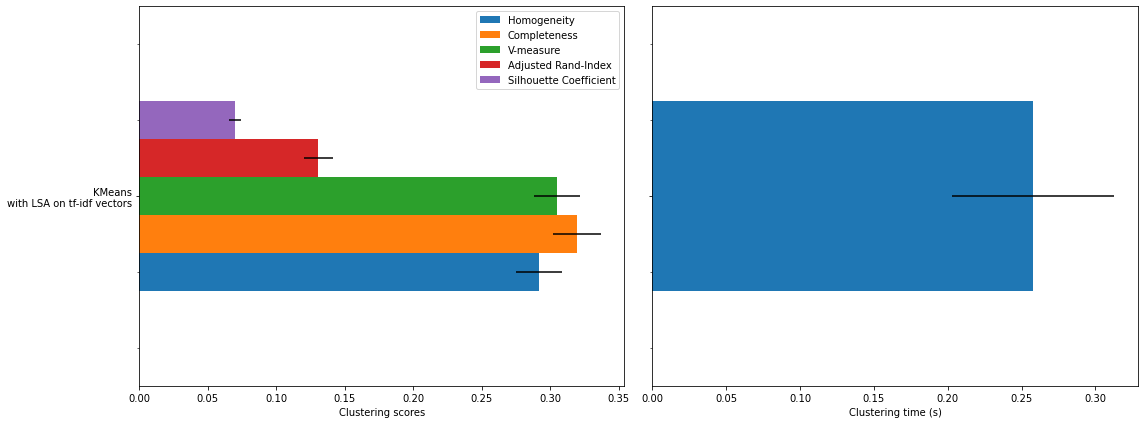

In [71]:
# Clustering evaluation summary
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

In [73]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="pca",n_iter=500, verbose=2)
tsne_mat = tsne.fit_transform(X_lsa)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.003s...
[t-SNE] Computed neighbors for 11314 samples in 7.258s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.296478
[t-SNE] Computed cond

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 94.7350998, gradient norm = 0.0005021 (50 iterations in 4.188s)
[t-SNE] Iteration 100: error = 94.6152649, gradient norm = 0.0002331 (50 iterations in 4.244s)
[t-SNE] Iteration 150: error = 94.5979996, gradient norm = 0.0001833 (50 iterations in 5.248s)
[t-SNE] Iteration 200: error = 94.5796127, gradient norm = 0.0001787 (50 iterations in 7.688s)
[t-SNE] Iteration 250: error = 94.5666962, gradient norm = 0.0001939 (50 iterations in 5.505s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.566696
[t-SNE] Iteration 300: error = 3.1576481, gradient norm = 0.0014062 (50 iterations in 3.766s)
[t-SNE] Iteration 350: error = 2.5610037, gradient norm = 0.0006129 (50 iterations in 4.689s)
[t-SNE] Iteration 400: error = 2.2977896, gradient norm = 0.0003613 (50 iterations in 4.470s)
[t-SNE] Iteration 450: error = 2.1454389, gradient norm = 0.0002466 (50 iterations in 5.159s)
[t-SNE] Iteration 500: error = 2.0449312, gradient norm = 0.0001842 (50 

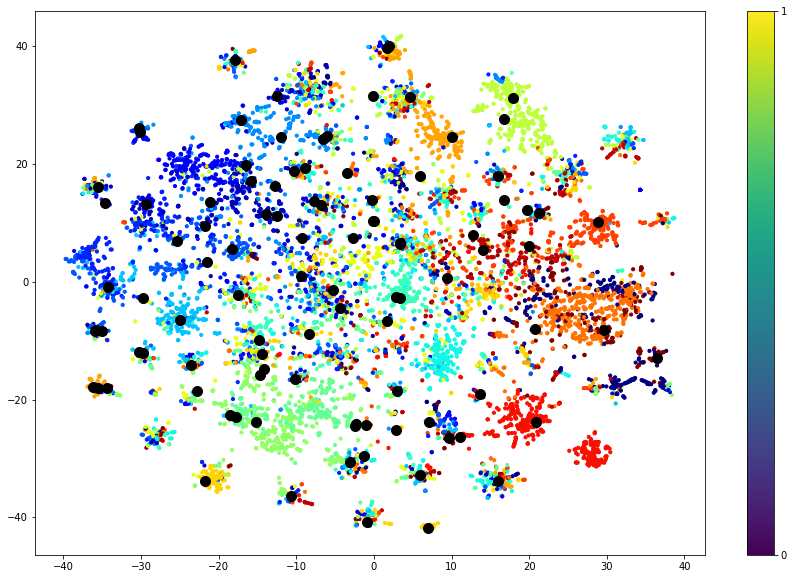

In [74]:
NN2cluster = np.argmax(np.abs(X_lsa), axis=0)
#import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

# 2) Latent Semantic Analysis (LSA <=> SVD) 


**Remember the LSA factorziation**: 
$$ 
\begin{matrix} 
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow 
&
\begin{pmatrix} 
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix} 
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix} 
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


**Good to remember**

Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

In [83]:
lsa = make_pipeline(TruncatedSVD(n_components=20), Normalizer(copy=False))
t0 = time.time()
U = lsa.fit_transform(vectors)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time.time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.216 s
Explained variance of the SVD step: 12.0%


In [76]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="pca",n_iter=1000, verbose=2)
tsne_mat = tsne.fit_transform(U)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.004s...
[t-SNE] Computed neighbors for 11314 samples in 4.656s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.296494
[t-SNE] Computed cond

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 94.7366180, gradient norm = 0.0005624 (50 iterations in 4.727s)
[t-SNE] Iteration 100: error = 94.6170425, gradient norm = 0.0002769 (50 iterations in 3.975s)
[t-SNE] Iteration 150: error = 94.5910721, gradient norm = 0.0001500 (50 iterations in 3.717s)
[t-SNE] Iteration 200: error = 94.5737839, gradient norm = 0.0001284 (50 iterations in 3.963s)
[t-SNE] Iteration 250: error = 94.5674515, gradient norm = 0.0001317 (50 iterations in 3.408s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.567451
[t-SNE] Iteration 300: error = 3.1530423, gradient norm = 0.0014126 (50 iterations in 4.866s)
[t-SNE] Iteration 350: error = 2.5561018, gradient norm = 0.0006091 (50 iterations in 4.798s)
[t-SNE] Iteration 400: error = 2.2920609, gradient norm = 0.0003655 (50 iterations in 3.378s)
[t-SNE] Iteration 450: error = 2.1400702, gradient norm = 0.0002446 (50 iterations in 3.137s)
[t-SNE] Iteration 500: error = 2.0399411, gradient norm = 0.0001836 (50 

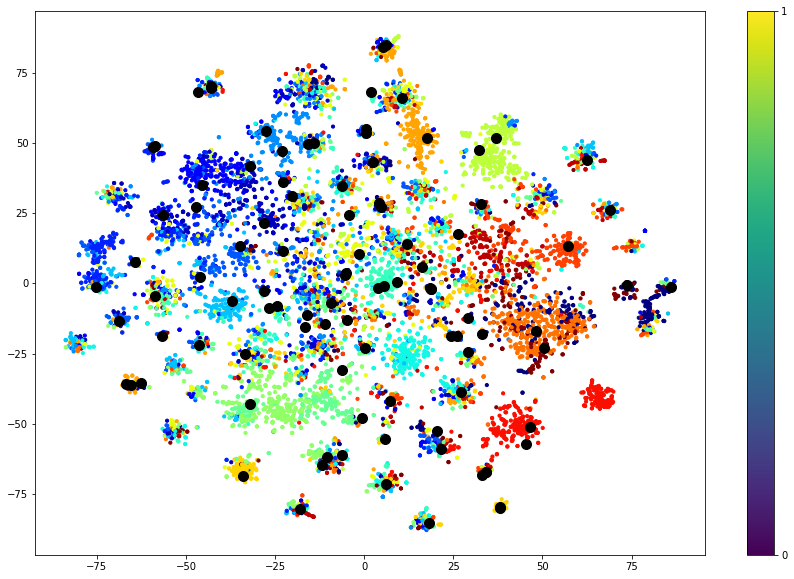

In [77]:
NN2cluster = np.argmax(np.abs(U), axis=0)
#import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

In [86]:
# applying lsa //////////////////////////////

from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(vectors, n_components=20, n_iter=100,
                              random_state=122)
#printing the topics
for i, comp in enumerate(VT):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
        print(" ")

Topic 0: 
edu
com
writes
article
university
don
posting
 
Topic 1: 
edu
university
cs
host
nntp
posting
windows
 
Topic 2: 
god
edu
people
jesus
think
bible
christian
 
Topic 3: 
com
edu
article
writes
netcom
nntp
posting
 
Topic 4: 
ca
team
game
nasa
year
gov
hockey
 
Topic 5: 
key
nasa
clipper
chip
encryption
gov
government
 
Topic 6: 
uk
ac
nasa
gov
space
cs
god
 
Topic 7: 
nasa
gov
space
god
jesus
research
center
 
Topic 8: 
cs
pitt
gordon
banks
science
computer
windows
 
Topic 9: 
key
ca
god
chip
clipper
encryption
escrow
 
Topic 10: 
windows
ca
israel
file
israeli
window
jews
 
Topic 11: 
ca
drive
israel
scsi
cs
israeli
jews
 
Topic 12: 
israel
sale
00
israeli
armenian
10
turkish
 
Topic 13: 
access
ohio
digex
state
pat
acs
usa
 
Topic 14: 
access
digex
drive
scsi
pat
net
keith
 
Topic 15: 
ohio
state
cleveland
netcom
cwru
acs
freenet
 
Topic 16: 
keith
caltech
host
posting
nntp
andrew
hp
 
Topic 17: 
andrew
car
cmu
cleveland
cwru
freenet
israel
 
Topic 18: 
cc
columbia
utexas
is

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.001s...
[t-SNE] Computed neighbors for 11314 samples in 4.709s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.008163
[t-SNE] Computed cond

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 92.7239685, gradient norm = 0.0013250 (50 iterations in 3.669s)
[t-SNE] Iteration 100: error = 91.9369965, gradient norm = 0.0009105 (50 iterations in 3.047s)
[t-SNE] Iteration 150: error = 91.6593399, gradient norm = 0.0007901 (50 iterations in 3.677s)
[t-SNE] Iteration 200: error = 91.5078278, gradient norm = 0.0006139 (50 iterations in 3.599s)
[t-SNE] Iteration 250: error = 91.3493729, gradient norm = 0.0007054 (50 iterations in 3.790s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.349373
[t-SNE] Iteration 300: error = 3.1655293, gradient norm = 0.0012876 (50 iterations in 3.826s)
[t-SNE] Iteration 350: error = 2.6499162, gradient norm = 0.0005621 (50 iterations in 5.081s)
[t-SNE] Iteration 400: error = 2.4129965, gradient norm = 0.0003411 (50 iterations in 5.852s)
[t-SNE] Iteration 450: error = 2.2718980, gradient norm = 0.0002363 (50 iterations in 4.664s)
[t-SNE] Iteration 500: error = 2.1777027, gradient norm = 0.0001759 (50 

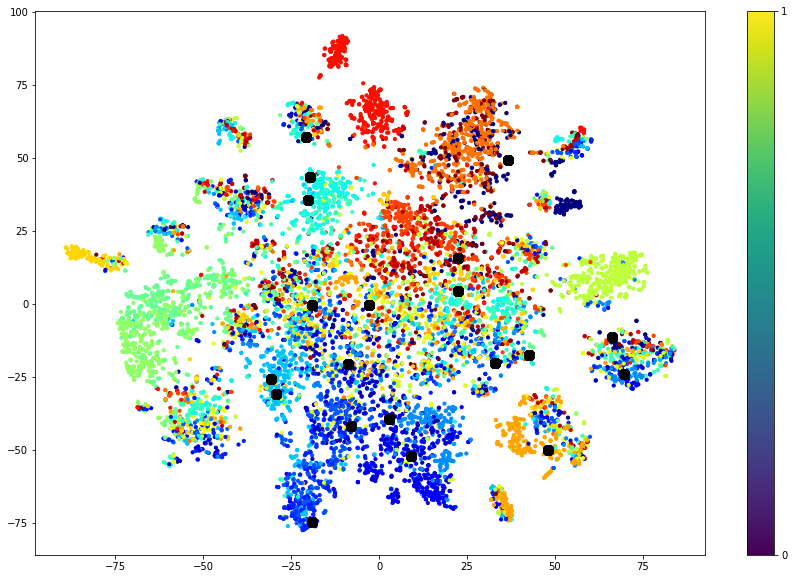

In [92]:
tsne_mat = tsne.fit_transform(U)

NN2cluster = np.argmax(np.abs(VT), axis=0)
#import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

In [98]:
ypred_lda = U.argmax(1)
evaluate(Y, ypred_lda)

Homogeneity: 0.203
Completeness: 0.210
V-measure: 0.207
Adjusted Rand-Index: 0.091


# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [99]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
48.02527841612162


In [113]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
# This produces a feature matrix of token counts, similar to what
# CountVectorizer would produce on text.
lda = LatentDirichletAllocation(
    n_components=20,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(vectors)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

In [117]:
ypred_ldirichleta = lda.transform(vectors).argmax(1)
evaluate(Y, ypred_ldirichleta)

Homogeneity: 0.245
Completeness: 0.311
V-measure: 0.274
Adjusted Rand-Index: 0.116


---

In [107]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)

    plt.show()

done in 25.245s.


IndexError: index 10 is out of bounds for axis 0 with size 10

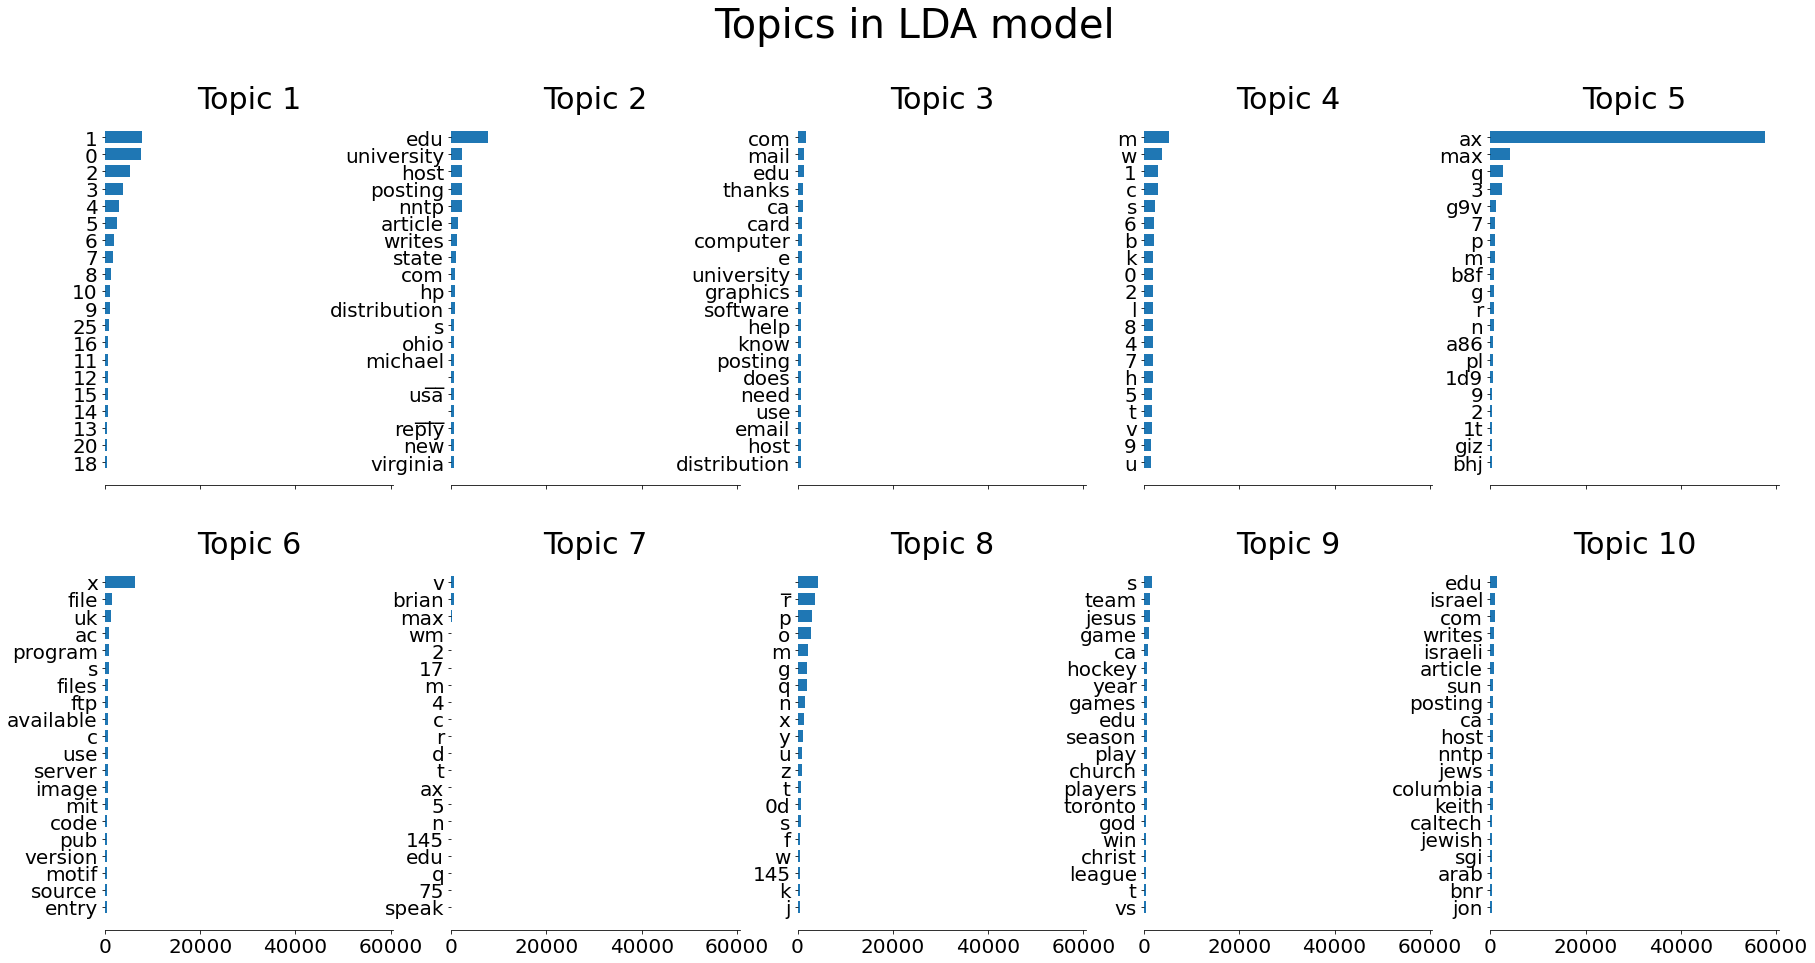

In [112]:
import time

n_samples = 2000
n_features = 1000
n_components = 20
n_top_words = 20
batch_size = 128
init = "nndsvda"

lda = LatentDirichletAllocation(
    n_components=20,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time.time()    
lda.fit(vectors)
print("done in %0.3fs." % (time.time() - t0))

tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

## LDA-viz

In [118]:
# pip install install pyldavis
from __future__ import print_function

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


pyLDAvis.sklearn.prepare(lda,vectors,vectorizer)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.176811  0.004874       1        1  15.356354
17    -0.192230 -0.016085       2        1  11.641654
4      0.370143  0.024833       3        1   8.455255
2     -0.114682 -0.006178       4        1   7.282715
3      0.326389  0.090321       5        1   5.929587
1     -0.130138  0.190217       6        1   5.162973
0      0.248671  0.142891       7        1   5.121811
5     -0.045949 -0.226377       8        1   4.988685
11    -0.128762 -0.067956       9        1   4.592156
16    -0.026431 -0.005111      10        1   4.441013
18    -0.132830  0.209272      11        1   4.424647
10    -0.153195 -0.107688      12        1   4.273719
8     -0.130427  0.083371      13        1   4.042147
15    -0.087819  0.009673      14        1   3.609257
7      0.331250 -0.014289      15        1   3.399183
9     -0.153616  0.180581      16        1   2.263696
14    -0.075518 -0.069296      17        1   2.031033
19     0.061788 -0.273322      18        1   1.541761
13    -0.010756 -0.123256      19        1   1.264403
6      0.220923 -0.026475      20        1   0.177951, topic_info=      Term          Freq         Total Category  logprob  loglift
146     ax  63268.000000  63268.000000  Default  30.0000  30.0000
347    edu  21293.000000  21293.000000  Default  29.0000  29.0000
587    max   4859.000000   4859.000000  Default  28.0000  28.0000
0        0   9617.000000   9617.000000  Default  27.0000  27.0000
9        1  15227.000000  15227.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
992      x      0.115026   9272.146173  Topic20  -9.7258  -4.9660
68       7      0.102982   5364.244828  Topic20  -9.8364  -4.5293
147      b      0.090346   3327.052152  Topic20  -9.9673  -4.1825
759  reply      0.087088   2471.370786  Topic20 -10.0040  -3.9220
530      l      0.086378   2919.105327  Topic20 -10.0122  -4.0966

[913 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         3  0.008318     0
0         5  0.217208     0
0         7  0.772028     0
0         8  0.000520     0
0        15  0.001872     0
...     ...       ...   ...
997      19  0.284623  york
999       3  0.076562     z
999       5  0.436034     z
999       8  0.096214     z
999      15  0.390997     z

[4431 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 18, 5, 3, 4, 2, 1, 6, 12, 17, 19, 11, 9, 16, 8, 10, 15, 20, 14, 7])

# Performances evaluation

**Compare the different approaches wrt three quantitative metrics.**

Sources:

https://medium.com/kuzok/news-documents-clustering-using-python-latent-semantic-analysis-b95c7b68861c

In [133]:
# KMeans
evaluate(Y, ypred_km)

Homogeneity: 0.004
Completeness: 0.245
V-measure: 0.007
Adjusted Rand-Index: -0.000


In [120]:
# LSA - Latent Semantic Analysis
ypred_lda = U.argmax(1)
evaluate(Y, ypred_lda)

Homogeneity: 0.203
Completeness: 0.210
V-measure: 0.207
Adjusted Rand-Index: 0.091


In [119]:
# LDA - Latent Dirihlet Allocation
ypred_ldirichleta = lda.transform(vectors).argmax(1)
evaluate(Y, ypred_ldirichleta)

Homogeneity: 0.245
Completeness: 0.311
V-measure: 0.274
Adjusted Rand-Index: 0.116
